# Import modules

In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [2]:
import tissuetypist as tt

/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/software/cellgen/team205/kk18/envs/tissuetypist_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# Prepare query data

For Visium HD data, we can use the trained model for a full transcriptome dataset, which is included in this package.<br>
Therefore, there is no need to train a model.

We recommend to use 8um-bin data.

### Read in adata

In [4]:
# read in raw count object
sample_id = 'HEA_FOET14880396'
path_to_adata = f'/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/{sample_id}_8um-bins_filtered.h5ad'
adata = sc.read_h5ad(path_to_adata)
# add section column
adata.obs['section'] = sample_id
# prepare coordinate columns
adata.obs['binned_8_row'] = [int(x.split('_')[2]) for x in adata.obs_names]
adata.obs['binned_8_col'] = [int(x.split('_')[3].replace('-1','')) for x in adata.obs_names]
print(adata.X.data[:5])
print(adata.shape)

[2. 1. 1. 1. 1.]
(311232, 18085)


In [5]:
section_col = 'section'

### Preprocess data

Below, with setting as `pseudobulk=True`, we are generating pseudo-bulk gene expression data using a sliding window approach. Specifically, the data will be segmented into adjacent windows to match the size of the low-resolution visium data, utilising the `squidpy.tl.sliding_window` function. For each defined window, gene expression data will be aggregated through summation. The resulting aggregated counts will be then normalized and log-transformed to prepare them for further pre-processing.

For the argument `pseudobulk_window_size`, for VisiumHD-8um data, window_size=6 will give roughly 50um size (8um x 6 = 48)

Making pseudobulk per sliding window...
### Total window number ###: 9471
### Average cell number per window ###: 32.9
Pseudobulk: summed per window and log-normalised.
Preparing expression data...
2446 genes will be used.
Calculating distance from tissue edge...


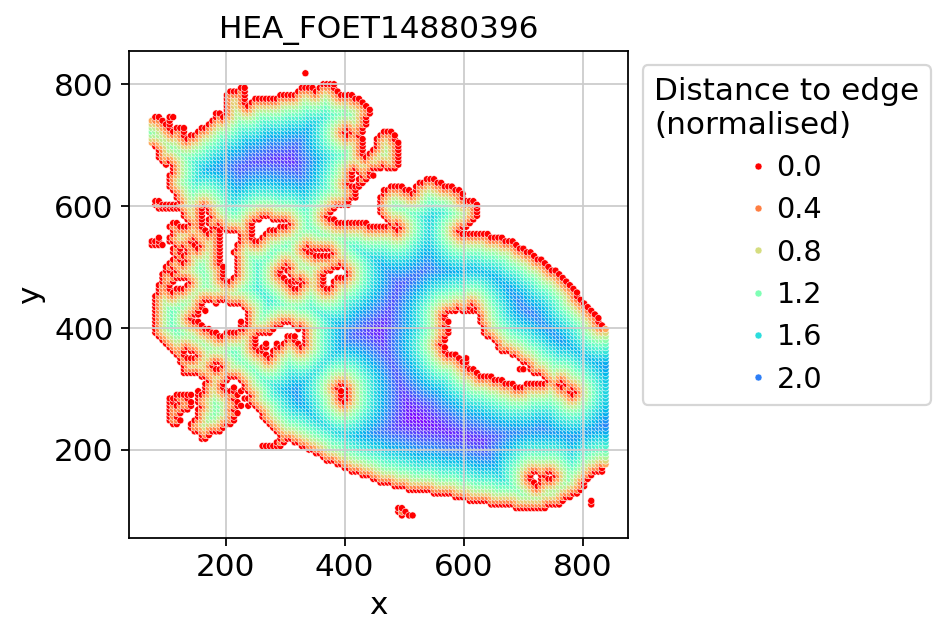

(9471, 4898)
CPU times: user 1min 4s, sys: 2.34 s, total: 1min 6s
Wall time: 1min 9s


,EGR3_own,MMP23B_own,TENM2_own,SH3GL3_own,PFN2_own,B3GNT5_own,PCNX3_own,NR2F2_own,ZFP36_own,USP32_own,...,MDFIC_neighbour-max,PTGS1_neighbour-max,CALU_neighbour-max,RNF145_neighbour-max,section,x,y,n_neighbours,is_edge,distance_to_edge
HEA_FOET14880396_window_74,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.855775,0.000000,0.0,...,1.842690,0.000000,2.780594,0.426463,HEA_FOET14880396,76.0,536.0,2.0,True,0.000000
HEA_FOET14880396_window_75,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.147602,0.0,...,1.842690,0.000000,2.453329,0.426463,HEA_FOET14880396,76.0,542.0,2.0,True,0.000000
HEA_FOET14880396_window_102,0.0,1.023133,0.000000,1.847775,1.518154,0.0,0.0,0.000000,0.000000,0.0,...,2.023093,0.661043,2.562277,0.493252,HEA_FOET14880396,76.0,704.0,2.0,False,0.551131
HEA_FOET14880396_window_103,0.0,0.000000,0.000000,2.023093,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,1.412643,0.661043,2.465838,0.869217,HEA_FOET14880396,76.0,710.0,3.0,False,0.771254
HEA_FOET14880396_window_104,0.0,0.000000,1.373348,1.373348,1.373348,0.0,0.0,0.905947,0.000000,0.0,...,2.023093,0.574757,2.369804,0.869217,HEA_FOET14880396,76.0,716.0,3.0,False,0.972289


In [6]:
%%time
query_df = tt.preprocess(adata,
                     section_col=section_col,
                     coord_columns = ('binned_8_col', 'binned_8_row'),
                     pseudobulk=True,
                     pseudobulk_window_size=6,
                     tile_type='square', # 'hexagon' or 'square'
                     plot=True
                    )
print(query_df.shape)
query_df.head()

The pre-processed dataframe includes:
* Gene expression data of each spot (suffix: `_own`)
* Gene expression data of neighbour spots (suffix: `_neighbour-max`)
* Section ID (`section`)
* XY coordinates (`x` and `y`)
* Distance to tissue edge (`distance_to_edge`)

# Predict

In [7]:
%%time
query_df = tt.predict(query_df,pipeline_dir=None)

Loading the default trained models for a full transcriptome dataset.
##### weight2neighbours-0.0_weight2edge-0 #####
number of features: 5207
predicting...
done!
##### weight2neighbours-0.3_weight2edge-5 #####
number of features: 5207
predicting...
done!
##### weight2neighbours-1.0_weight2edge-5 #####
number of features: 5207
predicting...
done!
CPU times: user 1.86 s, sys: 1.59 s, total: 3.46 s
Wall time: 3.65 s


# Plot results

In [8]:
AnnotationPalette={ 
    'Atrium':'#eac075',
        'Ventricle - Compact':'#f1acfa',
     'Ventricle - Trabeculated':'#f09951',
        'SAnode':'#8A2BE2',
        'AVnode':'#062b4a',
    'VCS - Proximal':'#FFFF00',
        'VCS - Distal':'#7FFFD4',
        'Epicardium':'#01ccc8',
        'Endocardium - Atrial':'#DC143C',
        'Endocardium - Ventricular':'#f53527',
        'Endocardial cusion':'#ff7e97',
        'Great vessel':'#ff9b6e',
    'Ductus arteriosus':'#8a6800',
        'Coronary vessel':'#206601',
        'Adventitia - Coronary':'#CAFF70',
     'Adventitia - GV':'#005aa0',
        'AV ring':'#e478ff',
    'Valves':'#3300FF',
    'LN':'#9088ff',
}

number of sections: 1


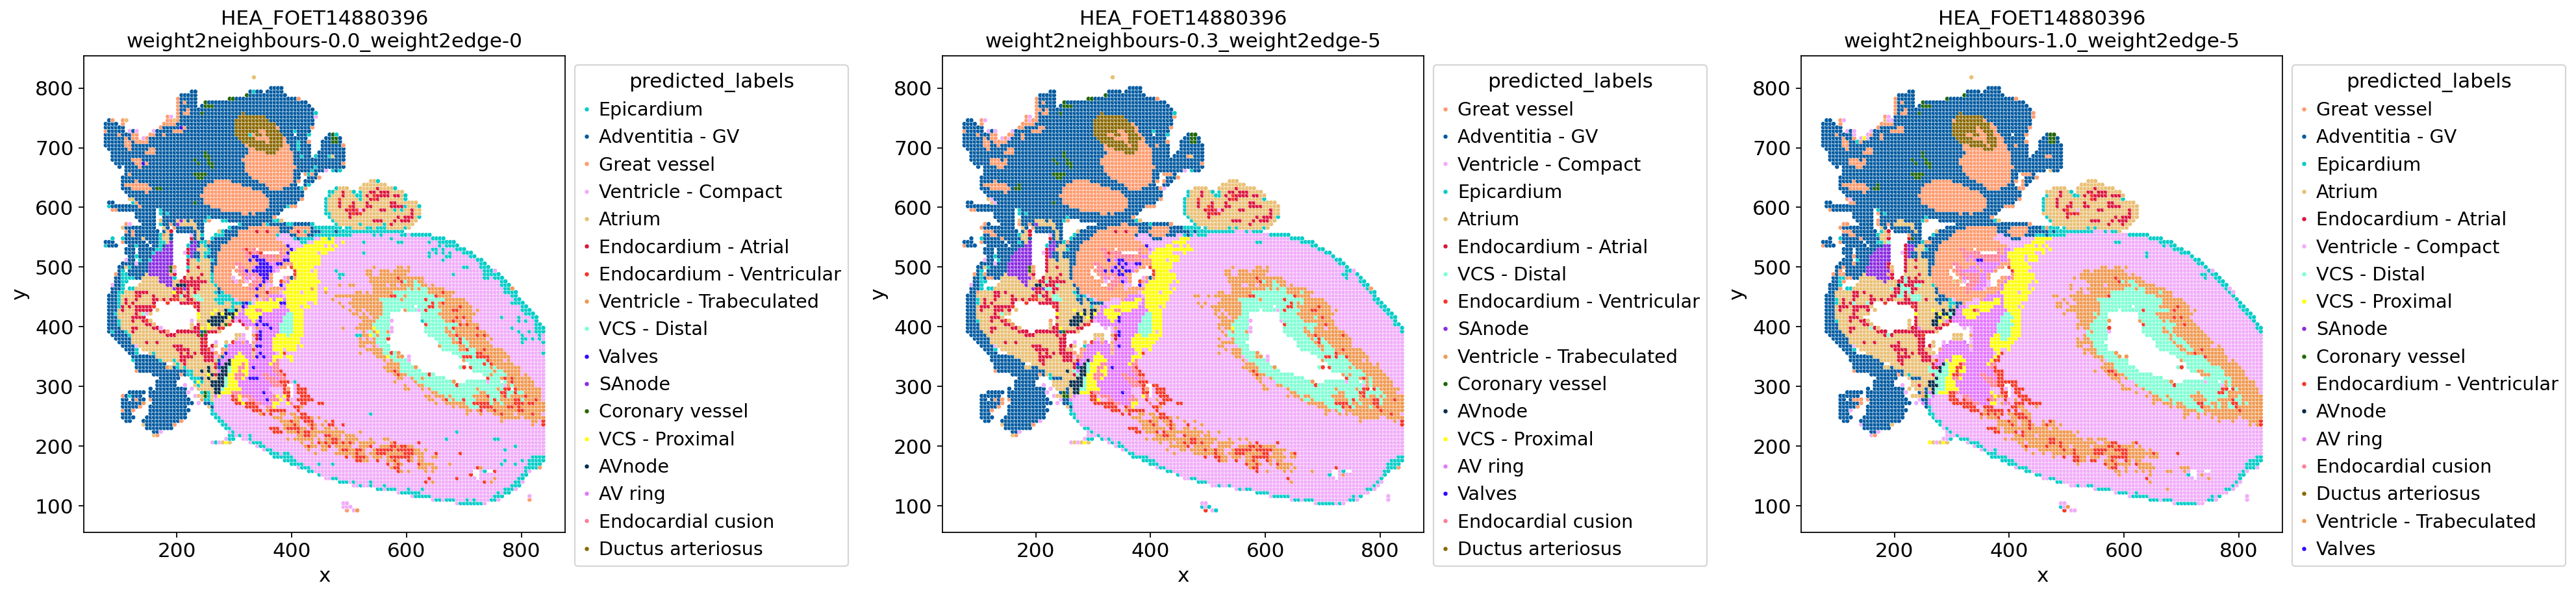

In [9]:
sections = set(query_df['section'])
print(f'number of sections: {len(sections)}')
predictions = [x for x in query_df.columns if 'predicted_labels_' in x]

plt.rcParams['axes.grid'] = False
fig, axs = plt.subplots(ncols=3,nrows=len(sections),figsize=(25,6*len(sections)))
axs = axs.flatten()
count=0
for i,section in enumerate(sections):
    # subset
    data_sub = query_df[query_df['section']==section]
    for j,col in enumerate(predictions):
        count = (i*3)+j
        pipeline_name = col.replace('predicted_labels_','')
        sns.scatterplot(
            x='x',y='y',hue=col,
            data=data_sub,
            s=10,palette=AnnotationPalette,ax=axs[count]
        )
        axs[count].set_title(f'{section}\n{pipeline_name}')
        axs[count].legend(title='predicted_labels',bbox_to_anchor=(1, 1))
fig.tight_layout()

# Select a condition and store the output to the original adata

In [11]:
adata = tt.prediction_to_adata(adata,
                         query_df,
                         weight_neighbour=0.3,
                         weight_edge=5,
                         sliding_window_col='sliding_window_assignment')
adata.obs

0 data don't have a predicted result


,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,binned_8_row,binned_8_col,sample,sliding_window_assignment,window_col,window_row,tt_prediction,section
s_008um_00301_00321-1,955,6.862758,1215.0,7.103322,19.917695,28.148148,37.860082,62.551440,28.0,3.367296,2.304527,955,301,321,HEA_FOET14880396,HEA_FOET14880396_window_5037,322.0,302.0,AV ring,HEA_FOET14880396
s_008um_00602_00290-1,1220,7.107425,1644.0,7.405496,19.099757,25.912409,37.956204,56.204380,34.0,3.555348,2.068127,1220,602,290,HEA_FOET14880396,HEA_FOET14880396_window_4477,292.0,602.0,Great vessel,HEA_FOET14880396
s_008um_00377_00750-1,718,6.577861,986.0,6.894670,26.774848,36.916836,47.464503,77.890467,66.0,4.204693,6.693712,718,377,750,HEA_FOET14880396,HEA_FOET14880396_window_13712,748.0,380.0,Ventricle - Trabeculated,HEA_FOET14880396
s_008um_00383_00696-1,616,6.424869,780.0,6.660575,25.512821,33.846154,46.666667,85.128205,44.0,3.806663,5.641026,616,383,696,HEA_FOET14880396,HEA_FOET14880396_window_12615,694.0,386.0,Ventricle - Trabeculated,HEA_FOET14880396
s_008um_00526_00291-1,864,6.762730,1177.0,7.071573,22.939677,31.435854,43.585387,69.073917,19.0,2.995732,1.614274,864,526,291,HEA_FOET14880396,HEA_FOET14880396_window_4464,292.0,524.0,Great vessel,HEA_FOET14880396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_008um_00653_00166-1,402,5.998937,478.0,6.171700,26.359833,36.820084,57.740586,100.000000,17.0,2.890372,3.556485,402,653,166,HEA_FOET14880396,HEA_FOET14880396_window_1924,166.0,656.0,Adventitia - GV,HEA_FOET14880396
s_008um_00353_00477-1,1155,7.052721,1667.0,7.419381,25.074985,31.913617,42.711458,60.707858,133.0,4.897840,7.978405,1155,353,477,HEA_FOET14880396,HEA_FOET14880396_window_8218,478.0,356.0,Ventricle - Compact,HEA_FOET14880396
s_008um_00565_00244-1,743,6.612041,852.0,6.748760,17.018779,24.530516,36.267606,71.478873,4.0,1.609438,0.469484,743,565,244,HEA_FOET14880396,HEA_FOET14880396_window_3495,244.0,566.0,Adventitia - GV,HEA_FOET14880396
s_008um_00373_00222-1,1138,7.037906,1741.0,7.462789,28.546812,35.152211,46.122918,63.354394,98.0,4.595120,5.628949,1138,373,222,HEA_FOET14880396,HEA_FOET14880396_window_2975,220.0,374.0,Atrium,HEA_FOET14880396


In [12]:
# save adata
adata.write(path_to_adata)
path_to_adata

'/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/HEA_FOET14880396_8um-bins_filtered.h5ad'